In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import missingno as msno
from scipy import interpolate

       WELLNUM         DEPTH        DTC  DTS       DEN         GR       NEU  \
0            0  14121.660105   89.64610  NaN  2.577700   88.85730  0.277790   
1            0  14122.160105   96.01520  NaN  2.474800  120.89490  0.294806   
2            0  14122.660105  104.04570  NaN  2.333800  153.51950  0.447361   
3            0  14123.160105  113.50100  NaN  2.235800  182.85310  0.579637   
4            0  14123.660105  117.78170  NaN  2.227800  256.19600  0.556317   
...        ...           ...        ...  ...       ...        ...       ...   
42304        8  12142.500000   64.57612  NaN  2.613020   32.91600  0.109335   
42305        8  12143.000000   66.20669  NaN  2.614332   28.76523  0.099368   
42306        8  12143.500000   67.43187  NaN  2.620479   25.70403  0.097774   
42307        8  12144.000000   66.56465  NaN  2.623435   22.94222  0.089295   
42308        8  12144.500000   66.92158  NaN  2.617516   22.30438  0.091876   

           PEF      RDEP      RMED      PHIF   SW  

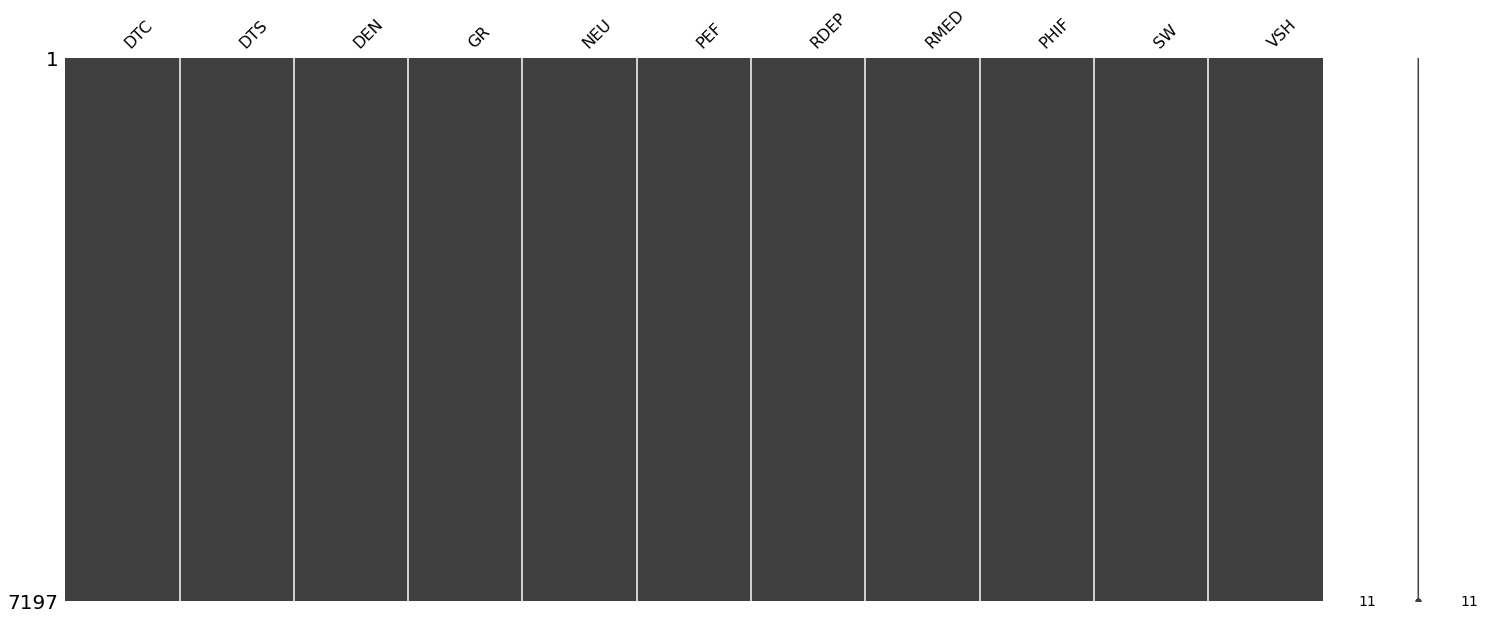

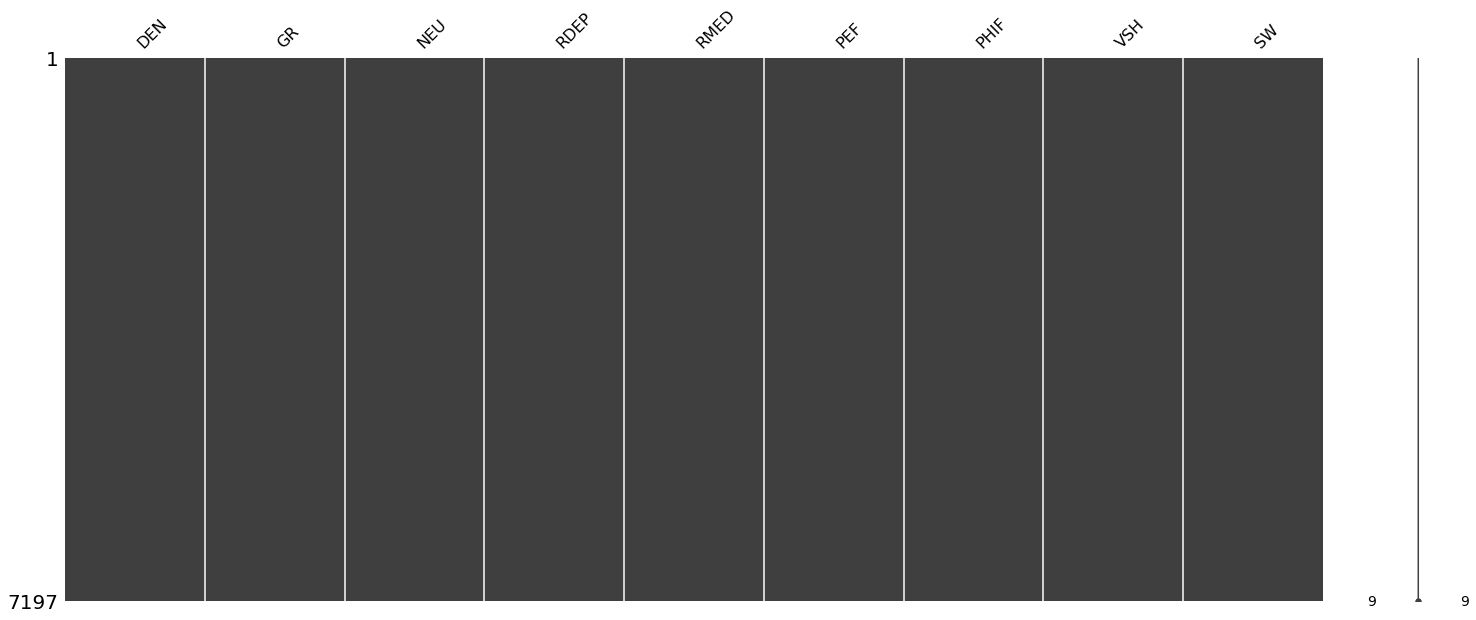

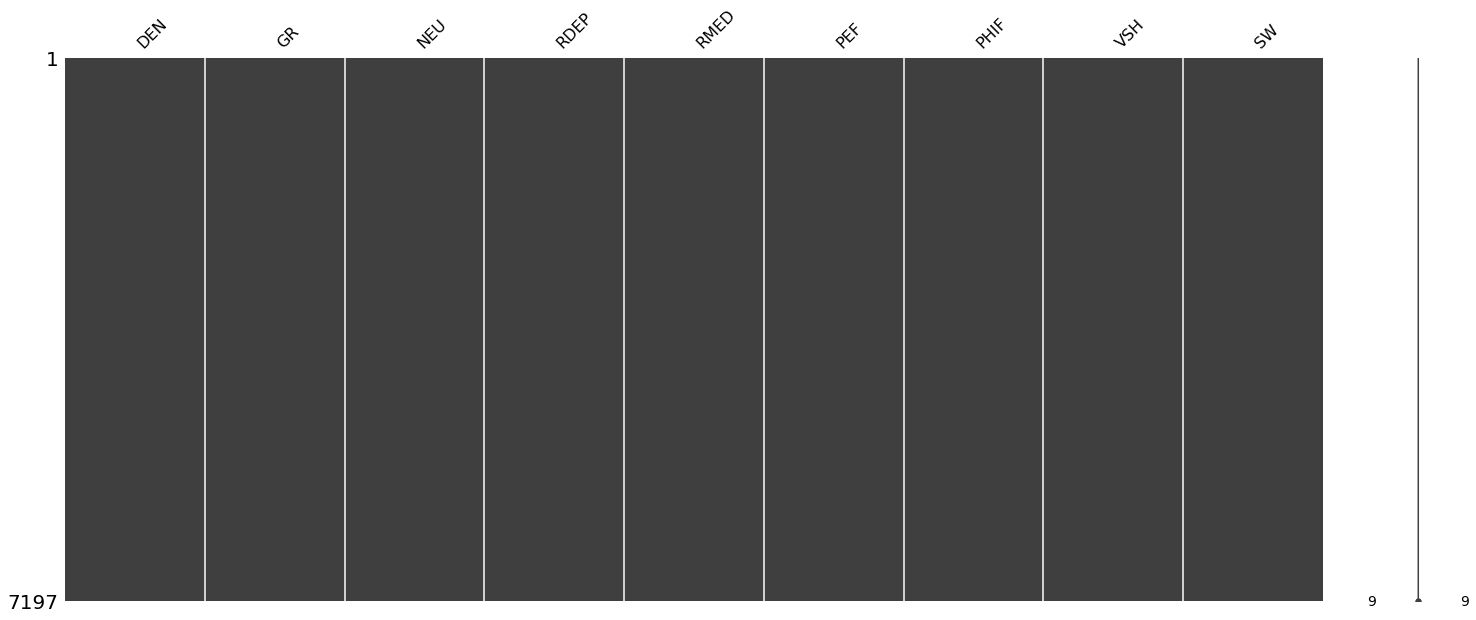

In [2]:
#Load Dataset
train_path = r"/Users/astromeria/PycharmProjects/SPWLA_2021_Geolatinas/dataset/train_dataset_clean.csv"
train_data = pd.read_csv(train_path)
print(train_data)

discarded =  ["WELLNUM", "DEPTH"]
targets = ["DTC"]
features = ["DEN","GR","NEU", "RDEP","RMED", "PEF",  'PHIF', 'VSH', 'SW']

train_data = train_data.drop(columns=discarded)

train_data = train_data.dropna()

#train_data = train_data.sample(n=1000,replace=False)
print(len(train_data))

msno.matrix(train_data)
#separate in x (inputs) and y(targets or outputs)

x_train = train_data.loc[:, features]
y_train = train_data.loc[:, targets]
msno.matrix(x_train)
x_train = x_train.interpolate()
pef_mean = np.mean(x_train["PEF"])
print(pef_mean)
x_train['PEF'] = x_train['PEF'].fillna(pef_mean)
#pef_mean = np.mean(x_train["DTS"])
#print(pef_mean)
#x_train['DTS'] = x_train['DTS'].fillna(pef_mean)
msno.matrix(x_train)

#adjust values of targets:
#SW 0-1
#0<PHIF
# 0<VSH 
print(y_train.describe())
#x_train.loc[x_train["SW"] < 0, "SW"] = 0
#x_train.loc[x_train["SW"] > 1, "SW"] = 1
#x_train.loc[x_train["PHIF"] < 0, "PHIF"] = 0
#x_train.loc[x_train["PHIF"] > 1, "PHIF"] = 1
#x_train.loc[x_train["VSH"] < 0, "VSH"] = 0
print(x_train.describe())



x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.10)

#Normalize data
sc = StandardScaler()
x_train = pd.DataFrame(sc.fit_transform(x_train))
x_test = pd.DataFrame(sc.transform(x_test))

In [3]:
#model
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(x_train.keys())]),
    layers.Dropout(0.1),
   
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
   
    
    layers.Dense(len(y_train.keys()))
  ])
  optimizer = tf.keras.optimizers.Adam(0.001)
  model.compile(loss="mse",
                optimizer=optimizer,
                metrics=[ tf.keras.metrics.RootMeanSquaredError()])
  return model

#create a model instance
checkpoint_path = r"/Users/astromeria/Documents/SPWLA_competition/weights_data_fillers/DTC/DTC.h5"
checkpoint = keras.callbacks.ModelCheckpoint( checkpoint_path, save_best_only=True, monitor = "val_loss")
model = build_model()

history = model.fit(
  x_train, y_train,
  epochs=300, validation_split = 0.1, verbose=2, callbacks = checkpoint)#just 10% for validation to use most of the data on training

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
#plot_history(history)

2022-02-01 14:23:28.752054: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-01 14:23:28.796842: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/300
183/183 - 1s - loss: 2199.8669 - root_mean_squared_error: 46.9027 - val_loss: 225.0517 - val_root_mean_squared_error: 15.0017
Epoch 2/300
183/183 - 0s - loss: 245.0588 - root_mean_squared_error: 15.6544 - val_loss: 98.2596 - val_root_mean_squared_error: 9.9126
Epoch 3/300
183/183 - 0s - loss: 158.5562 - root_mean_squared_error: 12.5919 - val_loss: 59.6563 - val_root_mean_squared_error: 7.7237
Epoch 4/300
183/183 - 0s - loss: 123.5832 - root_mean_squared_error: 11.1168 - val_loss: 30.5841 - val_root_mean_squared_error: 5.5303
Epoch 5/300
183/183 - 0s - loss: 107.3931 - root_mean_squared_error: 10.3631 - val_loss: 22.8979 - val_root_mean_squared_error: 4.7852
Epoch 6/300
183/183 - 0s - loss: 103.1467 - root_mean_squared_error: 10.1561 - val_loss: 23.2417 - val_root_mean_squared_error: 4.8210
Epoch 7/300
183/183 - 0s - loss: 97.0791 - root_mean_squared_error: 9.8529 - val_loss: 17.8328 - val_root_mean_squared_error: 4.2229
Epoch 8/300
183/183 - 0s - loss: 91.1922 - root_mean_s

Epoch 63/300
183/183 - 0s - loss: 58.3313 - root_mean_squared_error: 7.6375 - val_loss: 12.7166 - val_root_mean_squared_error: 3.5660
Epoch 64/300
183/183 - 0s - loss: 58.3854 - root_mean_squared_error: 7.6410 - val_loss: 10.7436 - val_root_mean_squared_error: 3.2777
Epoch 65/300
183/183 - 0s - loss: 59.7800 - root_mean_squared_error: 7.7318 - val_loss: 8.5717 - val_root_mean_squared_error: 2.9278
Epoch 66/300
183/183 - 0s - loss: 58.7461 - root_mean_squared_error: 7.6646 - val_loss: 9.2937 - val_root_mean_squared_error: 3.0486
Epoch 67/300
183/183 - 0s - loss: 56.4416 - root_mean_squared_error: 7.5128 - val_loss: 15.3706 - val_root_mean_squared_error: 3.9205
Epoch 68/300
183/183 - 0s - loss: 61.7711 - root_mean_squared_error: 7.8595 - val_loss: 10.9249 - val_root_mean_squared_error: 3.3053
Epoch 69/300
183/183 - 0s - loss: 60.2002 - root_mean_squared_error: 7.7589 - val_loss: 8.4618 - val_root_mean_squared_error: 2.9089
Epoch 70/300
183/183 - 0s - loss: 57.5757 - root_mean_squared_err

Epoch 125/300
183/183 - 0s - loss: 49.6800 - root_mean_squared_error: 7.0484 - val_loss: 9.2930 - val_root_mean_squared_error: 3.0484
Epoch 126/300
183/183 - 0s - loss: 50.9048 - root_mean_squared_error: 7.1348 - val_loss: 8.0687 - val_root_mean_squared_error: 2.8405
Epoch 127/300
183/183 - 0s - loss: 49.7440 - root_mean_squared_error: 7.0529 - val_loss: 9.2684 - val_root_mean_squared_error: 3.0444
Epoch 128/300
183/183 - 0s - loss: 50.2564 - root_mean_squared_error: 7.0892 - val_loss: 7.7023 - val_root_mean_squared_error: 2.7753
Epoch 129/300
183/183 - 0s - loss: 48.2904 - root_mean_squared_error: 6.9491 - val_loss: 8.9355 - val_root_mean_squared_error: 2.9892
Epoch 130/300
183/183 - 0s - loss: 49.2211 - root_mean_squared_error: 7.0158 - val_loss: 8.1470 - val_root_mean_squared_error: 2.8543
Epoch 131/300
183/183 - 0s - loss: 50.2417 - root_mean_squared_error: 7.0881 - val_loss: 7.5666 - val_root_mean_squared_error: 2.7507
Epoch 132/300
183/183 - 0s - loss: 48.2053 - root_mean_squared

Epoch 187/300
183/183 - 0s - loss: 41.8679 - root_mean_squared_error: 6.4705 - val_loss: 7.2608 - val_root_mean_squared_error: 2.6946
Epoch 188/300
183/183 - 0s - loss: 42.3091 - root_mean_squared_error: 6.5045 - val_loss: 7.4644 - val_root_mean_squared_error: 2.7321
Epoch 189/300
183/183 - 0s - loss: 41.5018 - root_mean_squared_error: 6.4422 - val_loss: 6.6061 - val_root_mean_squared_error: 2.5702
Epoch 190/300
183/183 - 0s - loss: 41.4912 - root_mean_squared_error: 6.4414 - val_loss: 8.0444 - val_root_mean_squared_error: 2.8363
Epoch 191/300
183/183 - 0s - loss: 41.5549 - root_mean_squared_error: 6.4463 - val_loss: 6.8852 - val_root_mean_squared_error: 2.6240
Epoch 192/300
183/183 - 0s - loss: 39.3939 - root_mean_squared_error: 6.2765 - val_loss: 8.2437 - val_root_mean_squared_error: 2.8712
Epoch 193/300
183/183 - 0s - loss: 41.5847 - root_mean_squared_error: 6.4486 - val_loss: 7.1649 - val_root_mean_squared_error: 2.6767
Epoch 194/300
183/183 - 0s - loss: 40.5337 - root_mean_squared

Epoch 249/300
183/183 - 0s - loss: 34.7346 - root_mean_squared_error: 5.8936 - val_loss: 6.7489 - val_root_mean_squared_error: 2.5979
Epoch 250/300
183/183 - 0s - loss: 35.9441 - root_mean_squared_error: 5.9953 - val_loss: 6.6897 - val_root_mean_squared_error: 2.5864
Epoch 251/300
183/183 - 0s - loss: 34.8311 - root_mean_squared_error: 5.9018 - val_loss: 6.7062 - val_root_mean_squared_error: 2.5896
Epoch 252/300
183/183 - 0s - loss: 34.8584 - root_mean_squared_error: 5.9041 - val_loss: 6.2727 - val_root_mean_squared_error: 2.5045
Epoch 253/300
183/183 - 0s - loss: 34.1607 - root_mean_squared_error: 5.8447 - val_loss: 6.3533 - val_root_mean_squared_error: 2.5206
Epoch 254/300
183/183 - 0s - loss: 36.1609 - root_mean_squared_error: 6.0134 - val_loss: 6.6516 - val_root_mean_squared_error: 2.5791
Epoch 255/300
183/183 - 0s - loss: 34.5476 - root_mean_squared_error: 5.8777 - val_loss: 6.6213 - val_root_mean_squared_error: 2.5732
Epoch 256/300
183/183 - 0s - loss: 35.6286 - root_mean_squared

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,epoch
295,30.871923,5.556251,5.730805,2.393910,295
296,31.589172,5.620425,5.914217,2.431916,296
297,30.195024,5.495000,5.933861,2.435952,297
298,30.410509,5.514573,6.050539,2.459784,298
299,30.857006,5.554908,7.034455,2.652255,299


23/23 - 0s - loss: 5.4411 - root_mean_squared_error: 2.3326
<bound method NDFrame.head of            DTC
18573  78.9505
17857  90.8658
8200   72.2247
33183  88.4965
5609   70.8451
...        ...
6464   76.8559
7406   85.9440
18191  86.2018
8674   75.0612
8295   72.9068

[720 rows x 1 columns]>


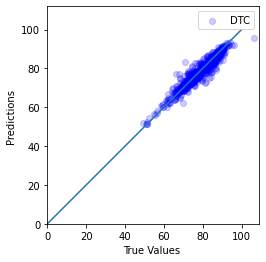

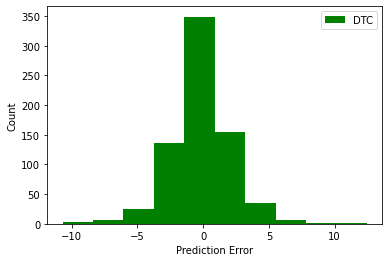

In [4]:
model.load_weights(checkpoint_path)

loss, mse = model.evaluate(x_test, y_test, verbose=2)
test_predictions = model.predict(x_test)
print(y_test.head)

col_names_y = [ "DTC"]
plt.scatter(y_test["DTC"], test_predictions[:,0], color = "blue", label = col_names_y[0], alpha=0.2)




           
plt.xlabel('True Values ')
plt.ylabel('Predictions ')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.legend()
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


error = test_predictions - np.asarray(y_test)

plt.hist(error[:,0], color = "green", label = col_names_y[0])


plt.legend()
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

       WELLNUM         DEPTH        DTC  DTS       DEN         GR       NEU  \
0            0  14121.660105   89.64610  NaN  2.577700   88.85730  0.277790   
1            0  14122.160105   96.01520  NaN  2.474800  120.89490  0.294806   
2            0  14122.660105  104.04570  NaN  2.333800  153.51950  0.447361   
3            0  14123.160105  113.50100  NaN  2.235800  182.85310  0.579637   
4            0  14123.660105  117.78170  NaN  2.227800  256.19600  0.556317   
...        ...           ...        ...  ...       ...        ...       ...   
42304        8  12142.500000   64.57612  NaN  2.613020   32.91600  0.109335   
42305        8  12143.000000   66.20669  NaN  2.614332   28.76523  0.099368   
42306        8  12143.500000   67.43187  NaN  2.620479   25.70403  0.097774   
42307        8  12144.000000   66.56465  NaN  2.623435   22.94222  0.089295   
42308        8  12144.500000   66.92158  NaN  2.617516   22.30438  0.091876   

           PEF      RDEP      RMED      PHIF   SW  

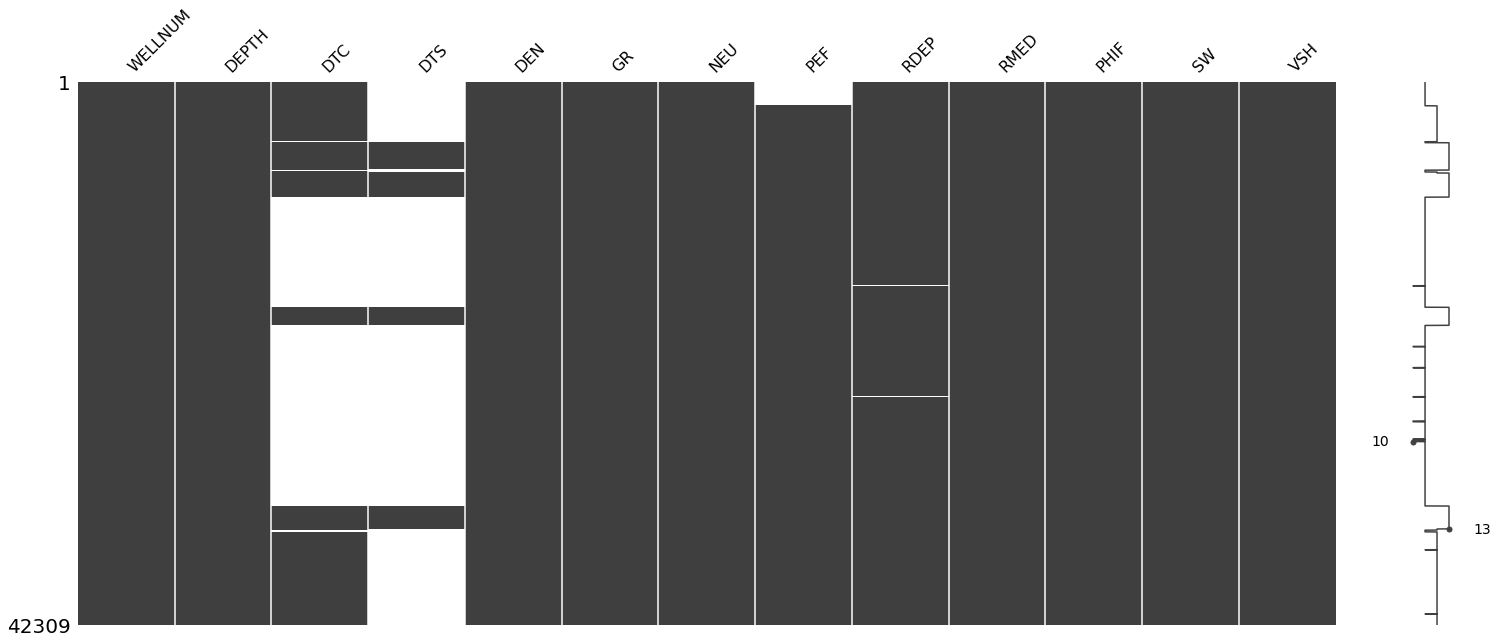

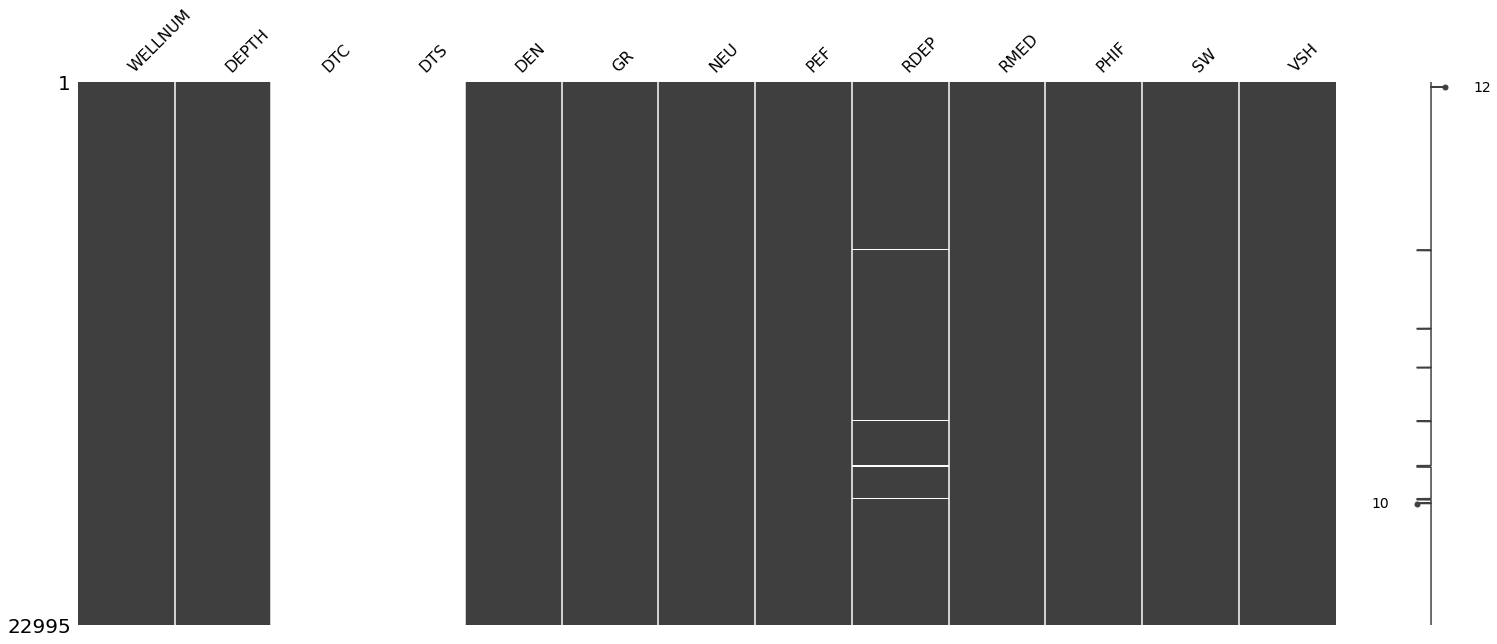

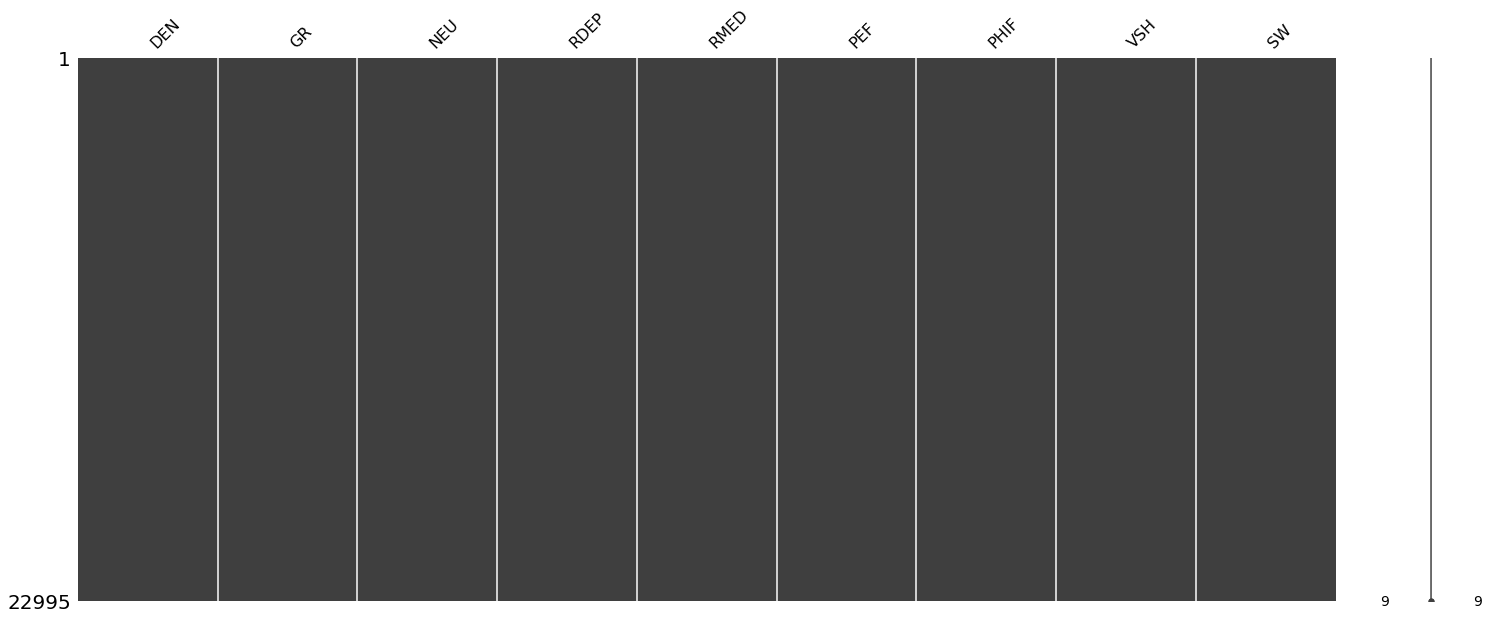

In [5]:
#Load dataset again and take apart the rows where DTc is nan to prepare for prediction

#Load Dataset
train_path = r"/Users/astromeria/PycharmProjects/SPWLA_2021_Geolatinas/dataset/train_dataset_clean.csv"
train_data = pd.read_csv(train_path)
print(train_data)

discarded =  ["WELLNUM", "DEPTH"]
targets = ["DTC"]
features = ["DEN","GR","NEU", "RDEP","RMED", "PEF",  'PHIF', 'VSH', 'SW']
msno.matrix(train_data)

train_data = train_data.loc[~train_data.index.isin(train_data.dropna(subset=["DTC"]).index)] #only keeps where DTC is nan
#only keep the columns of interest 
x_predict = train_data.loc[:, features]
#keep apart depth and wellnum for later
indexes_columns = train_data.loc[:,discarded]
x_predict = x_predict.interpolate()
pef_mean = np.mean(x_predict["PEF"])
print(pef_mean)
x_predict['PEF'] = x_predict['PEF'].fillna(pef_mean)
msno.matrix(train_data)

#adjust values to ranges
#x_predict.loc[x_predict["SW"] < 0, "SW"] = 0
#x_predict.loc[x_predict["SW"] > 1, "SW"] = 1
#x_predict.loc[x_predict["PHIF"] < 0, "PHIF"] = 0
#x_predict.loc[x_predict["PHIF"] > 1, "PHIF"] = 1
#x_predict.loc[x_predict["VSH"] < 0, "VSH"] = 0
msno.matrix(x_predict)
#normalize data as training data
x_predict = pd.DataFrame(sc.transform(x_predict))




In [6]:
model = build_model()
model.load_weights(checkpoint_path)

#loss, mse = model.evaluate(x_test, y_test, verbose=2)
dtc_predictions = model.predict(x_predict)

print("Predictions len: ", len(dtc_predictions))
print(len(indexes_columns))
indexes_columns['DTC'] = dtc_predictions
print(indexes_columns.describe())
print(indexes_columns)
dtc_predictions = indexes_columns
#convert predictions to dataframe and save
dtc_predictions = pd.DataFrame(data=dtc_predictions, index=None)
dtc_predictions.to_csv("./dtc_predictions/dtc_2.csv", index=False)

Predictions len:  22995
22995
            WELLNUM         DEPTH           DTC
count  22995.000000  22995.000000  22995.000000
mean       5.205740  12774.160463     82.016045
std        1.045242   1319.013208      5.979947
min        1.000000  10574.150000     52.054928
25%        4.000000  11703.245000     78.790928
50%        6.000000  12592.520000     83.185257
75%        6.000000  13726.545000     86.496750
max        7.000000  15566.930000    132.958176
       WELLNUM     DEPTH        DTC
4674         1  11808.07  76.938538
4675         1  11808.40  76.545731
4676         1  11808.73  76.007607
4677         1  11809.05  75.294006
4678         1  11809.38  74.665405
...        ...       ...        ...
35038        7  14881.56  80.906342
35039        7  14881.89  81.111404
35040        7  14882.22  81.077545
35041        7  14882.55  80.787010
35042        7  14882.87  80.793060

[22995 rows x 3 columns]



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


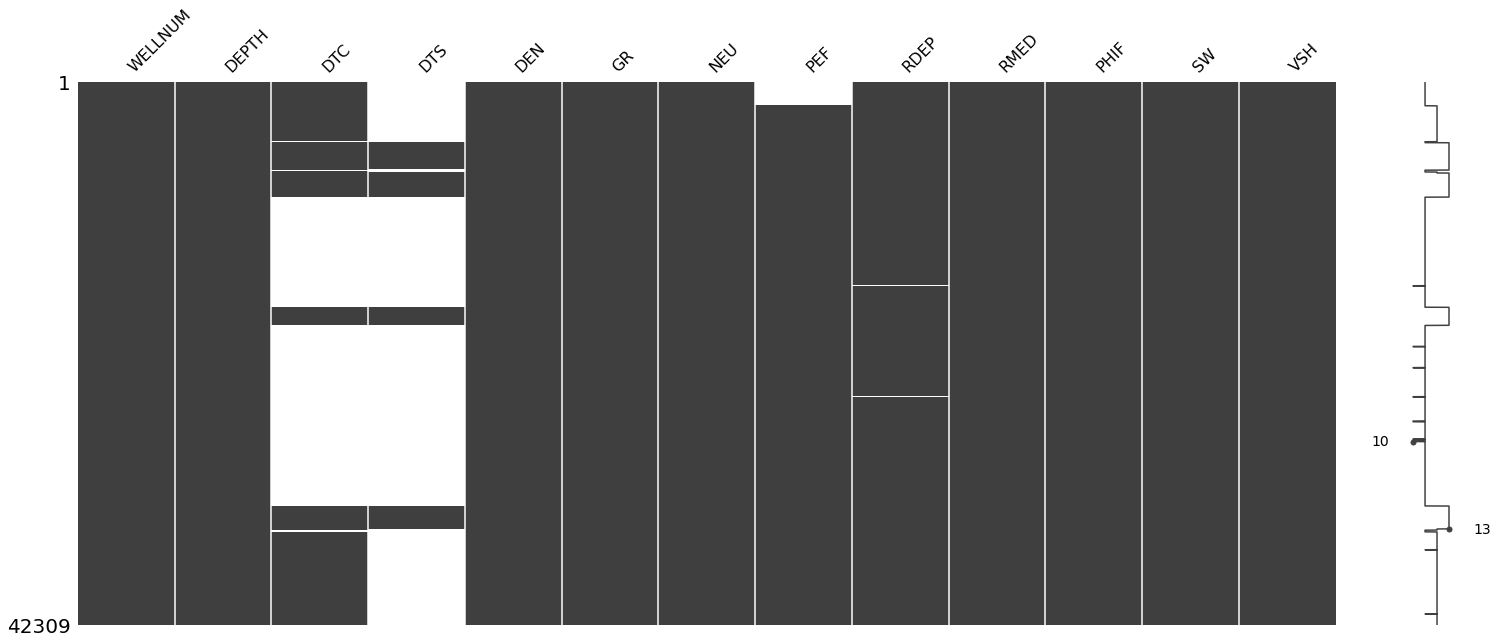

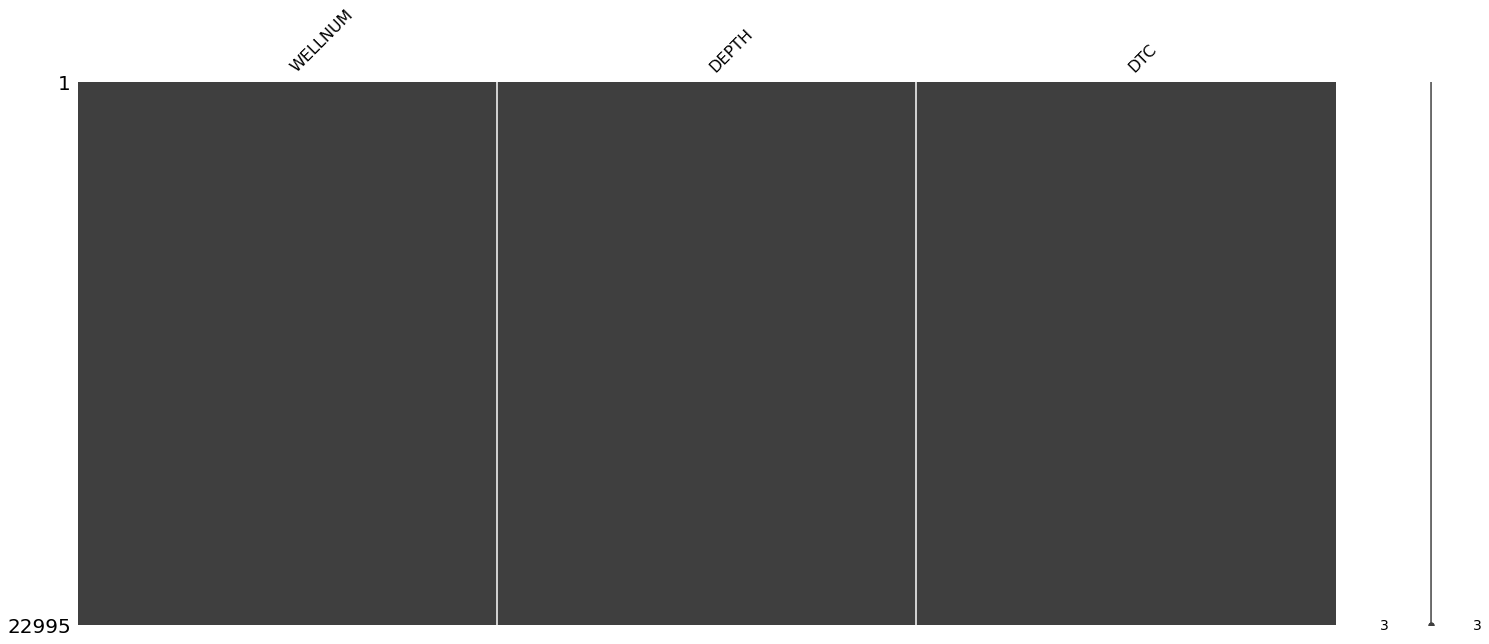

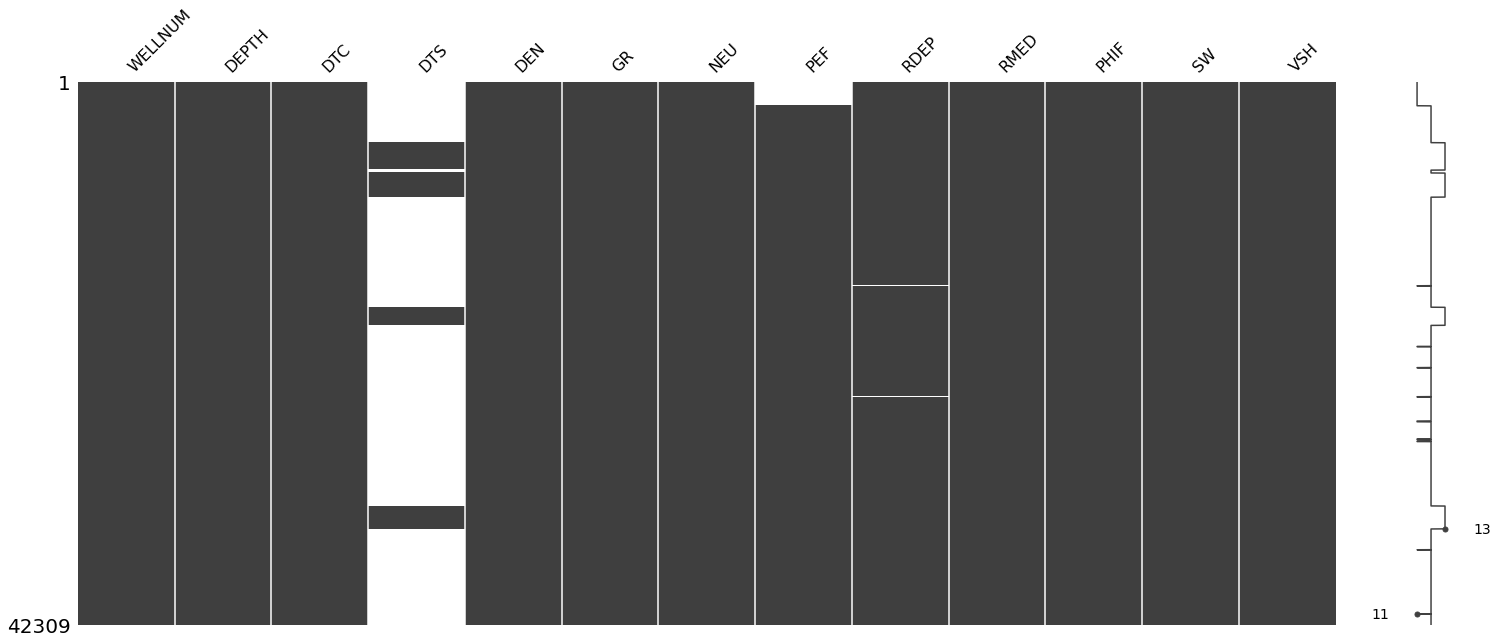

In [7]:
import math
#fill the clean_dataset values for DTC with the predictions
#Load Dataset
train_path = r"/Users/astromeria/PycharmProjects/SPWLA_2021_Geolatinas/dataset/train_dataset_clean.csv"
train_data = pd.read_csv(train_path)
msno.matrix(train_data)
msno.matrix(dtc_predictions)



for index,cell in enumerate(train_data["DTC"]):
    if math.isnan(cell):
        train_data["DTC"][index] = dtc_predictions["DTC"][index]
msno.matrix(train_data)

#save dataset with DTC filled
train_data.to_csv("./dtc_predictions/train_dataset_dtc_2.csv")
